In [1]:
%load_ext autotime

import os
import sys
import math
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import matplotlib.patches as mpatches
import nltk

from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

In [2]:
train_df = pd.read_csv('../data/raw/liar_dataset/train.tsv', delimiter='\t', header = None)
valid_df = pd.read_csv('../data/raw/liar_dataset/valid.tsv', delimiter='\t', header = None)
test_df = pd.read_csv('../data/raw/liar_dataset/test.tsv', delimiter='\t', header = None)

time: 66.8 ms


In [3]:
test_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,11972.json,true,Building a wall on the U.S.-Mexico border will...,immigration,rick-perry,Governor,Texas,republican,30,30,42,23,18,Radio interview
1,11685.json,false,Wisconsin is on pace to double the number of l...,jobs,katrina-shankland,State representative,Wisconsin,democrat,2,1,0,0,0,a news conference
2,11096.json,false,Says John McCain has done nothing to help the ...,"military,veterans,voting-record",donald-trump,President-Elect,New York,republican,63,114,51,37,61,comments on ABC's This Week.
3,5209.json,half-true,Suzanne Bonamici supports a plan that will cut...,"medicare,message-machine-2012,campaign-adverti...",rob-cornilles,consultant,Oregon,republican,1,1,3,1,1,a radio show
4,9524.json,pants-fire,When asked by a reporter whether hes at the ce...,"campaign-finance,legal-issues,campaign-adverti...",state-democratic-party-wisconsin,NaN,Wisconsin,democrat,5,7,2,2,7,a web video


time: 25.9 ms


In [4]:
def map_f(x):
    '''
    Mapping the label column.
    
    The function maps 'mostly-true' and 'true' from the label column to 0 
    and rest to 1. This creates a classification target as required for 
    the problem.
    
    Parameters
    ----------
    x : Variable from pandas Series
    
    Returns
    -------
    None
    '''
    if x=='mostly-true' or x == 'true':
        return 0
    else:
        return 1
    
train = pd.DataFrame()
valid = pd.DataFrame()
test = pd.DataFrame()

train['text'] = train_df[2]
train['label'] = train_df[1].apply(map_f)

valid['text'] = valid_df[2]
valid['label'] = valid_df[1].apply(map_f)

test['text'] = train_df[2]
test['label'] = test_df[1].apply(map_f)


time: 18.9 ms


In [5]:
len(train), len(valid), len(test)

(10240, 1284, 10240)

time: 4.99 ms


In [6]:
X_train = pd.concat([train, valid])['text']
Y_train = pd.concat([train, valid])['label']
X_test = test['text']
Y_test = test['label']

time: 3.99 ms


Text(0.5, 1.0, 'Number of real and fake news')

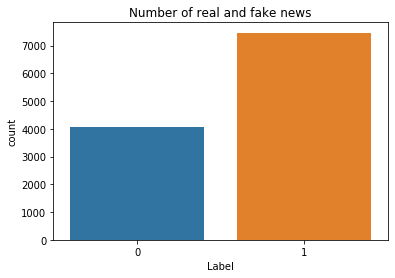

time: 131 ms


In [7]:
sns.countplot(Y_train)
plt.xlabel('Label')
plt.title('Number of real and fake news')

In [8]:
max_words = 1000
max_len = 150
tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(X_train)
sequences = tok.texts_to_sequences(X_train)
sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len)

time: 546 ms


In [9]:
def LSTM_model():
    '''
    Builds the LSTM Network.
    
    The function builds LSTM network by taking word embeddings as input and
    using LSTM, Dense, Dropout, Dense layer in the specified order. 'ReLU'
    is used as activation function in the network and 'sigmoid' is used as
    activation function for the classification layer.
    
    Parameters
    ----------
    None
    '''
    inputs = Input(name='inputs',shape=[max_len])
    layer = Embedding(max_words,50,input_length=max_len)(inputs)
    layer = LSTM(64)(layer)
    layer = Dense(256,name='FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(1,name='out_layer')(layer)
    layer = Activation('sigmoid')(layer)
    model = Model(inputs=inputs,outputs=layer)
    return model

time: 996 µs


In [12]:
model = LSTM_model()
model.summary()
model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, 150)]             0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 150, 50)           50000     
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                29440     
_________________________________________________________________
FC1 (Dense)                  (None, 256)               16640     
_________________________________________________________________
activation_2 (Activation)    (None, 256)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
out_layer (Dense)            (None, 1)                 257 

In [13]:
model.fit(sequences_matrix,Y_train,batch_size=128,epochs=20,validation_split=0.2)

Train on 9219 samples, validate on 2305 samples
Epoch 1/20
9219/9219 [==============================] - 26s 3ms/sample - loss: 0.6523 - acc: 0.6428 - val_loss: 0.6208 - val_acc: 0.6651
Epoch 2/20
9219/9219 [==============================] - 24s 3ms/sample - loss: 0.6202 - acc: 0.6631 - val_loss: 0.6055 - val_acc: 0.6746
Epoch 3/20
9219/9219 [==============================] - 26s 3ms/sample - loss: 0.5976 - acc: 0.6815 - val_loss: 0.6133 - val_acc: 0.6729
Epoch 4/20
9219/9219 [==============================] - 25s 3ms/sample - loss: 0.5838 - acc: 0.6945 - val_loss: 0.6252 - val_acc: 0.6651
Epoch 5/20
9219/9219 [==============================] - 23s 3ms/sample - loss: 0.5712 - acc: 0.7050 - val_loss: 0.6443 - val_acc: 0.6399
Epoch 6/20
9219/9219 [==============================] - 23s 3ms/sample - loss: 0.5587 - acc: 0.7191 - val_loss: 0.6728 - val_acc: 0.5961
Epoch 7/20
9219/9219 [==============================] - 22s 2ms/sample - loss: 0.5490 - acc: 0.7285 - val_loss: 0.7197 - val_acc: 

time: 6min 41s


In [36]:
X_test = X_test[:1267]
Y_test = Y_test[:1267]

time: 996 µs


In [37]:
test_sequences = tok.texts_to_sequences(X_test)
test_sequences_matrix = sequence.pad_sequences(test_sequences,maxlen=max_len)

time: 30.9 ms


In [38]:
y_pred = model.predict(test_sequences_matrix)
y_pred = y_pred.argmax(axis=-1)

time: 648 ms


In [39]:
from sklearn.metrics import classification_report
print(classification_report(Y_test.fillna(0), y_pred))

              precision    recall  f1-score   support

         0.0       0.35      1.00      0.52       449
         1.0       0.00      0.00      0.00       818

    accuracy                           0.35      1267
   macro avg       0.18      0.50      0.26      1267
weighted avg       0.13      0.35      0.19      1267

time: 7.97 ms


C:\Users\sahitesh\AppData\Roaming\Python\Python37\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
